In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Random Hierarchy for NAICS (no data modifications)
Neural Network With NAICS Embedding Layer + dummy hieararchy. Add NAICS embedding to model.  Add additional dummy levels to the hieararchy.   Do not do any data manipulation, so unseen codes get mapped to an input that is not in training

Use the dataset with no missing values. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, \
    Concatenate, Reshape, concatenate, Flatten
import tensorflow.keras.metrics as km

In [6]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model 

In [7]:
# Imputer object for easy dataset conversion to NN friendly format
from sba_nn.sba_nn import sbnn_imputer 
from sba_nn.sba_nn.sbnn_imputer import NNImputer

## Input Data

In [8]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [9]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [10]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)
naics_max_levels

{'NAICS': 1170,
 'NAICS_5': 764,
 'NAICS_4': 345,
 'NAICS_3': 107,
 'NAICS_sector': 21}

## Modify Data


In [11]:
# Group counts
features_naics_hier = ['NAICS_4', 'NAICS_3', 'NAICS_sector']
naics_counts = [sba_loans.drop_duplicates(f)['LoanNr_ChkDgt'].count() for f in features_naics_hier]
naics_counts

[345, 106, 20]

In [12]:
naics_df = sba_loans[['NAICS_orig']].drop_duplicates() 

In [13]:
sba_loans[['NAICS_orig']].isna().value_counts()

NAICS_orig
False         695500
Name: count, dtype: int64

In [14]:
def make_grp(data, k, grp_name = 'rgrp', seed=34535):
    np.random.seed(seed+k)
    return pd.Series(np.random.randint(2,k+2,size=len(data)),
                    name = grp_name, index=data.index)

In [15]:
naics_k_assign = pd.concat([make_grp(naics_df, k, f'rgrp_{k:03d}') for k in naics_counts], axis=1)

In [16]:
# Save the new columns
naics_rand_map = pd.concat([naics_df, naics_k_assign], axis=1) 
naics_rand_map.to_parquet(Path(setup.temp_path).joinpath('41_DATA_naics_groups.parquet'))

In [17]:
naics_rand_map.describe()

,rgrp_345,rgrp_106,rgrp_020
count,1311.000000,1311.000000,1311.000000
mean,179.608696,55.018307,11.488177
std,99.166789,30.679699,5.859394
min,2.000000,2.000000,2.000000
25%,97.500000,28.000000,6.500000
50%,185.000000,55.000000,11.000000
75%,267.500000,82.000000,17.000000
max,346.000000,107.000000,21.000000


In [18]:
naics_rand_map.head(2)

,NAICS_orig,rgrp_345,rgrp_106,rgrp_020
index,,,,
0,451120,181,89,11
1,722410,223,7,14


In [19]:
grp_features = list(naics_rand_map.columns)
grp_features

['NAICS_orig', 'rgrp_345', 'rgrp_106', 'rgrp_020']

In [20]:
# Apply to SBA loans

In [21]:
sba_loans = sba_loans.drop(columns=naics_k_assign.columns, errors='ignore') \
    .merge(naics_rand_map, how='left', on='NAICS_orig')

In [22]:
sba_loans['rgrp_345'].isna().value_counts()

rgrp_345
False    695500
Name: count, dtype: int64

In [23]:
imputer = NNImputer(features = None, naics_features = grp_features)

In [24]:
imputer.fit(sba_loans[sba_loans['dset'] == 'train'])

In [25]:
naics_out = imputer.transform(sba_loans)[grp_features]

In [26]:
sba_loans = pd.concat([sba_loans[[c for c in sba_loans.columns if c not in grp_features]],
                          naics_out], axis=1)

In [27]:
sba_loans['rgrp_345'].isna().value_counts()

rgrp_345
False    695500
Name: count, dtype: int64

In [28]:
len_dict = sba_loans[sba_loans['dset'] == 'test'] \
    [grp_features] \
    .apply('max').astype('int').to_dict()
print(len_dict)

{'NAICS_orig': 1170, 'rgrp_345': 337, 'rgrp_106': 107, 'rgrp_020': 21}


In [29]:
naics_out.apply('min').astype('int').to_dict()

{'NAICS_orig': 1, 'rgrp_345': 1, 'rgrp_106': 2, 'rgrp_020': 2}

In [30]:
# Save data
sba_loans[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS'] + list(naics_rand_map.columns)] \
     .to_parquet(Path(setup.temp_path).joinpath('41_DATA_naics_groups_loans.parquet'))

In [31]:
with open(Path(setup.temp_path).joinpath('41_DATA_naics_max_encodings.pkl'), 'wb') as fout:
    pickle.dump(len_dict, fout)

# Features

In [32]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [33]:
# Use analagous embedding dimensions
features_grp_all = ['NAICS'] + features_naics_hier
grp_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_grp_all]

In [34]:
print(len_dict)
print(grp_emb_dim)

{'NAICS_orig': 1170, 'rgrp_345': 337, 'rgrp_106': 107, 'rgrp_020': 21}
[8, 4, 4, 2]


##### Datasets for train, validation

In [35]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric].set_index('LoanNr_ChkDgt').sort_index()

In [36]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 10), y:(446848,)


In [37]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 10), y:(95604,)


In [38]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


In [39]:
X_hier = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in grp_features]

In [40]:
X_hier_train = [Xn[Xn['dset'] == 'train'].drop(columns='dset') for Xn in X_hier]
X_hier_val =  [Xn[Xn['dset'] == 'val'].drop(columns='dset') for Xn in X_hier]

## Create, fit model

In [41]:
list(len_dict.values())

[1170, 337, 107, 21]

In [42]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         list(len_dict.values()),
                                         grp_emb_dim,
                                         naics_embedding_names = grp_features,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-29 17:30:25.621421: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-29 17:30:25.621448: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-29 17:30:25.621456: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-29 17:30:25.621494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-29 17:30:25.621512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [43]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_01 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_02 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                            

In [44]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [45]:
this_history = this_model.fit([X_train] + X_hier_train, y_train,
                              validation_data=([X_val] + X_hier_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs,
                              callbacks=[callback])

Epoch 1/20


2024-05-29 17:30:26.658531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - ETA: 0s - loss: 0.4625 - auc: 0.3365 - auc_1: 0.6996

2024-05-29 17:34:33.620933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 270s 19ms/step - loss: 0.4625 - auc: 0.3365 - auc_1: 0.6996 - val_loss: 0.4543 - val_auc: 0.3707 - val_auc_1: 0.7232
Epoch 2/20
13964/13964 [==============================] - 260s 19ms/step - loss: 0.4546 - auc: 0.3586 - auc_1: 0.7164 - val_loss: 0.4518 - val_auc: 0.3776 - val_auc_1: 0.7270
Epoch 3/20
13964/13964 [==============================] - 269s 19ms/step - loss: 0.4523 - auc: 0.3658 - auc_1: 0.7211 - val_loss: 0.4509 - val_auc: 0.3796 - val_auc_1: 0.7280
Epoch 4/20
13964/13964 [==============================] - 274s 20ms/step - loss: 0.4509 - auc: 0.3696 - auc_1: 0.7240 - val_loss: 0.4510 - val_auc: 0.3818 - val_auc_1: 0.7292
Epoch 5/20
13964/13964 [==============================] - 265s 19ms/step - loss: 0.4501 - auc: 0.3730 - auc_1: 0.7256 - val_loss: 0.4504 - val_auc: 0.3851 - val_auc_1: 0.7308
Epoch 6/20
13964/13964 [==============================] - 255s 18ms/step - loss: 0.4495 - auc: 0.3756 - auc_1: 0.7269 - val_loss: 0.4503

In [46]:
this_history_df = sbnn_model.process_history(this_history)

In [47]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('41_REPORT_fit_history.csv'))

<Axes: >

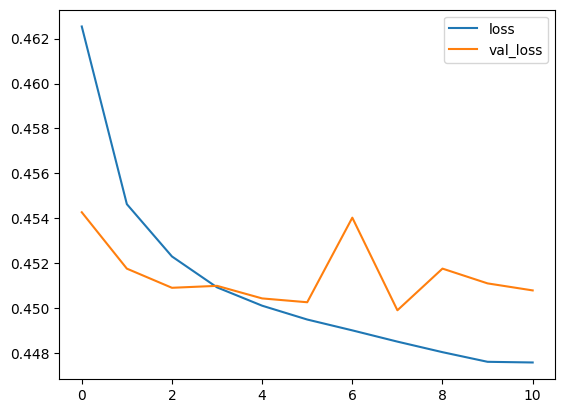

In [48]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

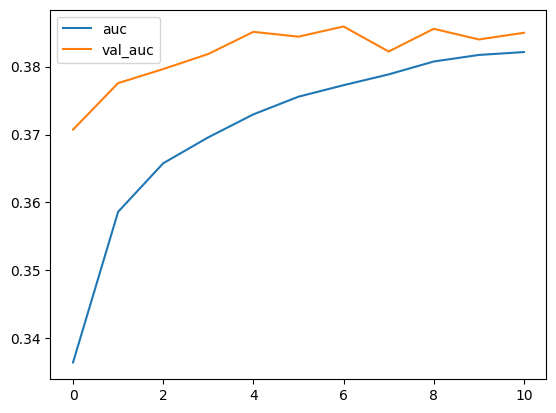

In [49]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

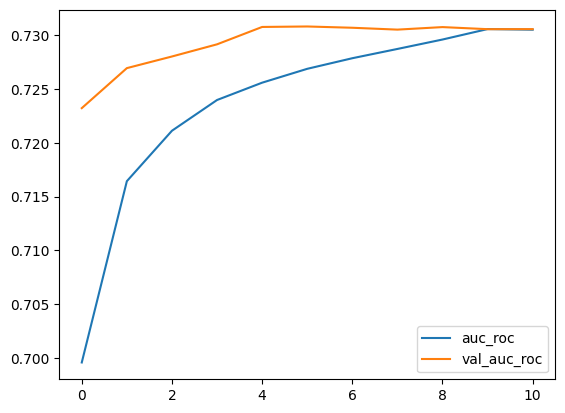

In [50]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [51]:
this_model.save(Path(setup.temp_path).joinpath('41_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [52]:
X_hier = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in grp_features]

In [53]:
all_predictions = this_model.predict([X.drop(columns='dset')] +
                                     [Xn.drop(columns='dset') for Xn in X_hier])

   93/21735 [..............................] - ETA: 35s

2024-05-29 18:11:29.814323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 37s 2ms/step


In [54]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [55]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.00000,0.32166
target,0.32166,1.00000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [56]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [57]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [58]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
10,0.20,0.454450
11,0.22,0.452915
9,0.18,0.451817


In [59]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.2

##### Append binary predictions to probability predictions

In [60]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [61]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.55606
1    0.44394
Name: proportion, dtype: float64

In [62]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('41_DATA_predictions.parquet'))

## Metrics

In [63]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('41_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.608750,0.438147,0.308412,0.756284,0.360844,0.716696,NaN
1,train,0.655180,0.454450,0.334191,0.709912,0.393192,0.737005,NaN
2,val,0.652368,0.450743,0.332431,0.699800,0.385070,0.730608,NaN
0,test,0.651015,0.448045,0.330098,0.697141,0.381350,0.727226,0.0
1,test,0.538502,0.425192,0.282787,0.856507,0.342043,0.714865,1.0
